In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-credit-card-dataset-for-machine-exam/credit_record.csv
/kaggle/input/a-credit-card-dataset-for-machine-exam/application_record.csv


# Import Libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Load and Merge Data

**Load the Datasets**

In [3]:
application_df = pd.read_csv('/kaggle/input/a-credit-card-dataset-for-machine-exam/application_record.csv', encoding='latin1')
credit_df = pd.read_csv('/kaggle/input/a-credit-card-dataset-for-machine-exam/credit_record.csv', encoding='latin1')

**Preview the Data**

In [4]:
application_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


**Aggregate credit data**

In [6]:
# Aggregate credit data (e.g., delinquent counts and maximum STATUS value)
credit_summary = credit_df.groupby('ID').agg({
    'STATUS': lambda x: sum(int(status) for status in x if status.isdigit()),
    'MONTHS_BALANCE': 'count'
}).rename(columns={'STATUS': 'Delinquent_Months', 'MONTHS_BALANCE': 'Total_Months'})

**Merge Datasets**

In [7]:
merged_df = pd.merge(application_df, credit_summary, on='ID', how='inner')

In [8]:
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Delinquent_Months,Total_Months
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,16
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,15
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,30
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,5
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,5


In [9]:
merged_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'Delinquent_Months',
       'Total_Months'],
      dtype='object')

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [11]:
merged_df.shape

(36457, 20)

# Check Missing Values

In [12]:
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 OCCUPATION_TYPE    11323
dtype: int64


**Plot Missing Values**

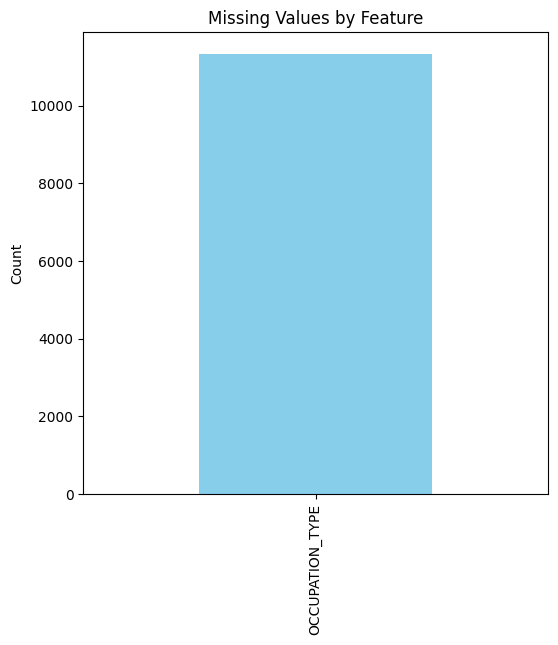

In [13]:
missing_values[missing_values > 0].sort_values(ascending=False).plot(kind='bar', figsize=(6, 6), color='skyblue')
plt.title("Missing Values by Feature")
plt.ylabel("Count")
plt.show()

In [14]:
merged_df['OCCUPATION_TYPE']

0                   NaN
1                   NaN
2        Security staff
3           Sales staff
4           Sales staff
              ...      
36452          Managers
36453    Medicine staff
36454    Medicine staff
36455       Sales staff
36456          Laborers
Name: OCCUPATION_TYPE, Length: 36457, dtype: object

In [15]:
merged_df.duplicated().sum()

0

# Feature Engineering

In [16]:
merged_df['Target'] = (merged_df['Delinquent_Months'] > 0).astype(int)

# Remove features with leakage
merged_df.drop(['Delinquent_Months', 'Total_Months'], axis=1, inplace=True)

# Retain `Target` and perform feature engineering
merged_df['Age'] = -merged_df['DAYS_BIRTH'] // 365
merged_df['Employment_Length'] = -merged_df['DAYS_EMPLOYED']
merged_df['Income_Per_Family_Member'] = merged_df['AMT_INCOME_TOTAL'] / merged_df['CNT_FAM_MEMBERS']

# Drop unnecessary columns
merged_df.drop(['ID', 'DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)


In [17]:
merged_df.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'Target', 'Age', 'Employment_Length',
       'Income_Per_Family_Member'],
      dtype='object')

# Encode Categorical Features

In [18]:
# Encode categorical variables
categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))
    label_encoders[col] = le


In [19]:
merged_df.isnull().sum()

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE             0
CNT_FAM_MEMBERS             0
Target                      0
Age                         0
Employment_Length           0
Income_Per_Family_Member    0
dtype: int64

# Check for Outliers

**IQR (Interquartile Range)**

In [20]:
Q1 = merged_df['AMT_INCOME_TOTAL'].quantile(0.25)
Q3 = merged_df['AMT_INCOME_TOTAL'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers
merged_df['Income_Outlier'] = (merged_df['AMT_INCOME_TOTAL'] < lower_bound) | (merged_df['AMT_INCOME_TOTAL'] > upper_bound)
print(merged_df['Income_Outlier'].value_counts())

Income_Outlier
False    34928
True      1529
Name: count, dtype: int64


# Visualization

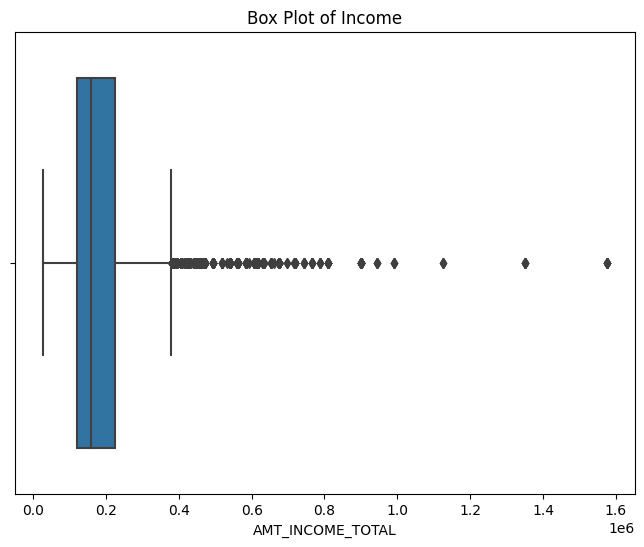

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=merged_df['AMT_INCOME_TOTAL'])
plt.title("Box Plot of Income")
plt.show()

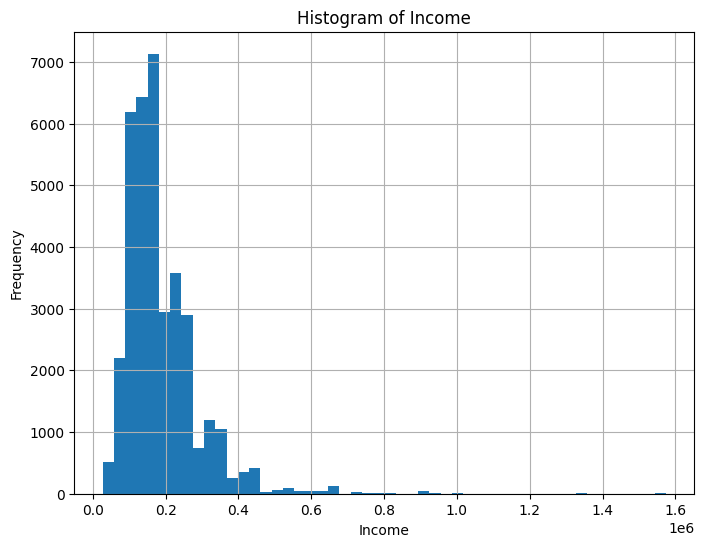

In [22]:
merged_df['AMT_INCOME_TOTAL'].hist(bins=50, figsize=(8, 6))
plt.title("Histogram of Income")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

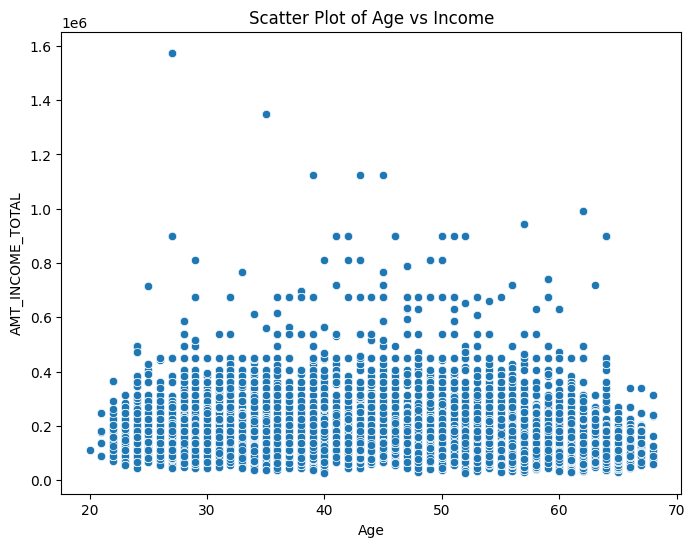

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df['Age'], y=merged_df['AMT_INCOME_TOTAL'])
plt.title("Scatter Plot of Age vs Income")
plt.show()

# Handle Outliers

In [24]:
#Replace outliers with the nearest valid boundary
merged_df['AMT_INCOME_TOTAL'] = np.where(
    merged_df['AMT_INCOME_TOTAL'] > upper_bound, upper_bound,
    np.where(merged_df['AMT_INCOME_TOTAL'] < lower_bound, lower_bound, merged_df['AMT_INCOME_TOTAL'])
)

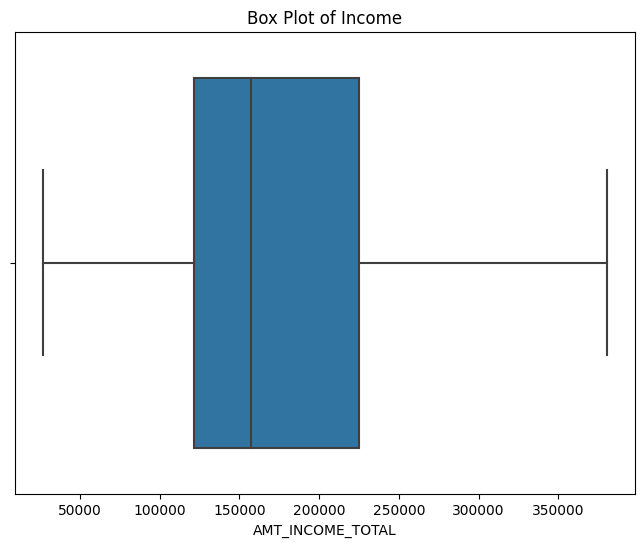

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=merged_df['AMT_INCOME_TOTAL'])
plt.title("Box Plot of Income")
plt.show()

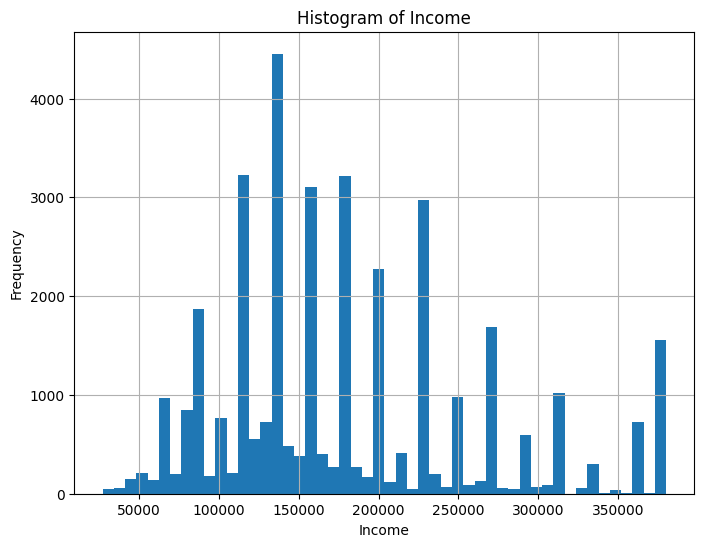

In [26]:
merged_df['AMT_INCOME_TOTAL'].hist(bins=50, figsize=(8, 6))
plt.title("Histogram of Income")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

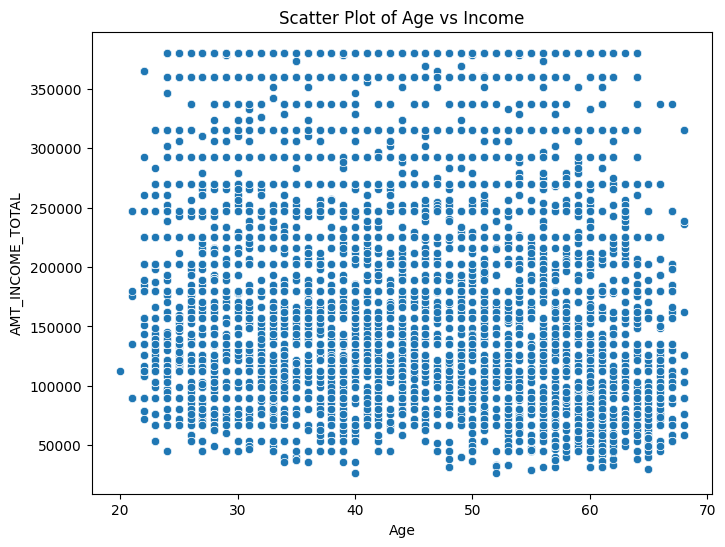

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df['Age'], y=merged_df['AMT_INCOME_TOTAL'])
plt.title("Scatter Plot of Age vs Income")
plt.show()

# Standardize Features and Splitting Data

In [28]:
#Declare feature vector and target variable
X = merged_df.drop('Target', axis=1)
y = merged_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25519, 19)
(10938, 19)
(25519,)
(10938,)


# Handle Class Imbalance

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Train a Gradient Boosting Classifier

In [31]:
#Train the model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
#Predict on test set
gb_pred = gb_model.predict(X_test)
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Evaluate Gradient Boosting model

In [32]:
print('GradientBoosting Model Accuracy Score: {0:0.2f}'. format(accuracy_score(y_test, gb_pred)*100)+ "%")
print("ROC AUC Score:", roc_auc_score(y_test, gb_pred_proba))
print("Classification Report:\n", classification_report(y_test, gb_pred))

GradientBoosting Model Accuracy Score: 87.83%
ROC AUC Score: 0.5948343778388205
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      9601
           1       0.75      0.01      0.01      1337

    accuracy                           0.88     10938
   macro avg       0.81      0.50      0.47     10938
weighted avg       0.86      0.88      0.82     10938



# Train a XGBoost Classifier

In [33]:
#Train the model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
#Predict on test set
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate XGBoost model

In [34]:
print('XGBoost Model Accuracy Score: {0:0.2f}'. format(accuracy_score(y_test, xgb_pred)*100)+ "%")
print("ROC AUC Score:", roc_auc_score(y_test, xgb_pred_proba))
print("Classification Report:\n", classification_report(y_test, xgb_pred))

XGBoost Model Accuracy Score: 88.33%
ROC AUC Score: 0.7239012359797663
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      9601
           1       0.62      0.12      0.19      1337

    accuracy                           0.88     10938
   macro avg       0.76      0.55      0.57     10938
weighted avg       0.86      0.88      0.85     10938

